In [ ]:
# Setup CSS Styles
from styles.plnbstyles import style_nb
style_nb("./styles/styles.css")

<div id="ps-header">
    <a href="https://developers.planet.com/" target="_blank">
<img src="https://www.planet.com/assets/logos/logo.svg" style="display:inline-block; margin-right: 10px;" width="100"/> <span style="font-size:18px">Developer Resource Center</span>
</a>
    
###  Planet Analytics API Tutorial

<h1 style="margin-top:10px;">Change Detection</h1>
</div>
<div class="content-block">

## Overview

1. [Introduction](#1.-Introduction) 

> Introduction to Planet Change Detection Feeds

2. [Change Detection Results](#2.-Change-Detection-Results)

> Investigate change detection results data
    
3. [Visualizing Change Detections](#3.-Visualizing-Change-Detections)
    
> Explore change detection datasets visually and against Planet imagery

4. [4. Change Detections Tip & Cue Tasking](#4.-Change-Detections-Tip-&-Cue-Tasking)
    
> Task high resolution collects using change detections

</div>

## 1. Introduction

In the previous notebook, we took a look at accessing Planet Analytic Feeds Results for both segmentation and object detection, and showed how to visualize Analytic Feeds data with maps and Planet imagery. 

In this notebook, we take a closer look at a specific type of change detection: Roads & Buildings Construction feed. We'll show how to use Analytic Feeds and Subscriptions to get this type of Change Detection result, and we'll show how this data can be visualized.

## 2. Change Detection Results

The semantic change detection product has been built through the following steps:

**Step 1 -**
Develop a high performing road detection model and leverage it to extract roads from imagery

**Step 2 -**
Run road detection over an AOI over an extended period of time, gathering as many data points as possible
From month to month, variations in atmosphere, shadows and other factors cause very small differences in the outputs over time leading to significant noise or “flicker”

**Step 3 -**
We de-noise the results by considering the temporal context of each pixel detected. This leads to a more consistent output, however it does introduce a “lag” in when we are able to detect change

**Step 4 -**
We then compare the most recent de-noised output with the previous de-noised output, pull out the differences and polygonize them.

### How do you define building and road construction?

By buildings, we refer to any 3D man-made structure that is static and where a person could take shelter in. For example, this includes residential buildings, stadiums, warehouses and storage tanks. 

By roads, we mean any man-made path designed for cars to drive on. 

Our definition of construction is the transition of land into these man-made structures. It does not include reconstruction or modification of existing structures. For example, new stories added to a building will not be detected.

### What does a change detection result represent?

In the building construction feed, a change result contains a geographic polygon that represents the footprint of a contiguous area where we have detected building construction. 
Thus, these polygons represent general built-up area, and may not identify individual buildings. They may be a group of small buildings clumped together, or a new adjacent wing of an existing building.

In the case of the road construction feed, the change results contain a linestring, instead of a polygon. This linestring represents the skeleton of a road segment that has been constructed. 

### When did the change actually occur?

Building and road construction is typically detected 3-4 months after the event took place. Our system performs statistical inference on the time series of images at the pixel level, and issues a change detection once there is enough confidence that a true transition occurred. Since we use images from Planet Basemaps, which have a monthly sampling rate, we cannot determine the week or day of an event. 


### Accessing Change Detection Results

Let's get started by accessing one of our Subscriptions. We'll see how we can get it's associated **Results** and we'll explore and visualize the data!

First we'll setup our API `base url` and `authentication` so we can make our `request`, just like in the previous tutorial.

In [ ]:
import os

# Configure Auth and Base Url

# Planet Analytics API base url
PAA_BASE_URL = "https://api.planet.com/analytics/"

# API Key Config
API_KEY = os.environ['PL_API_KEY']

# Setup Auth
BASIC_AUTH = (API_KEY, '')

# Check that everything is setup correctly
subscriptions_list_url = PAA_BASE_URL + 'subscriptions' + '?limit=1000'
resp = requests.get(subscriptions_list_url, auth=BASIC_AUTH)
if resp.status_code == 200:
    print('Yay, you can access the Analytics API')
    subscriptions = resp.json()['data']
    print('Available subscriptions:', len(subscriptions))
else:
    print('Something is wrong:', resp.content)

We'll make a couple helper functions for "pretty printing" our responses:

In [ ]:
# Pretty Print Helper
import pprint
pp = pprint.PrettyPrinter(indent=4)

# JSON Pretty Print Helper
import json

def jpp(data):
    print(json.dumps(data, indent=4))

#### Change Detection Subscription

Now let's use the `Requests` library to get a Change Detection Subscription. 

*Remember, we can see a list of available Subscriptions (and their `ids` by making a request to the `/subscriptions` endpoint. See the previous tutorial for more details.*

In [ ]:
# Request a Subscription

import requests

# Create a requests session to use
session =  requests.Session()

# Setup authentication on our requests session
session.auth=BASIC_AUTH

In [ ]:
# Define the Subscripton UUID
subscription_id = "dd2878b3-eaf0-4cff-b7f9-7a39d6f460a5"

# Construct the url for the Subscription
subscription_url = PAA_BASE_URL + 'subscriptions/' + subscription_id

print("Request URL: {}".format(subscription_url))

# Make the GET request for Subscriptions list 
subscription = session.get(subscription_url).json()

# Print subscription data
print("{} \n{}\nSubscription Id: {}\n".format(subscription['title'], subscription['description'], subscription['id']))

# Print the subscription object
print(json.dumps(subscription, sort_keys=True, indent=4))

The above output should look familiar from the previous tutorials. We see the title, AOI, TOI, and other metadata about the Subscription.

Now we can move on to getting the change detection items from the **Results** collection for this Subscription:

#### Change Detection Results Items

We can use the Subscription `id` property to get the `items` from the **Results** `collection`  for this Subscription. 

Since there are multiple pages of results returned from the API, we'll follow the `next` links provided in the API response and fetch all of the results using our `get_next_link` helper function:

In [ ]:
# Helper to get the "next" link
def get_next_link(links):
    for link in links:
        if link['rel'] == 'next':
            return link['href']

In [ ]:
# Get the url for the subscription's results collection items, using the 'rel' link from the subscription object
subscription_items_url = list(filter(lambda link: link['rel'] == 'results', subscription['links']))[0]['href']

print("Subscription Items URL:\n{}\n".format(subscription_items_url))

# Get subscription results items (Change Detections)
subscription_items = session.get(subscription_items_url).json()

# First next link
next_link =  get_next_link(subscription_items['links'])

# Loop to get all pages of features
while next_link:
    
    print('Getting page: {}'.format(next_link))
    
    # Use "next" link to request next page
    next_collection = session.get(next_link).json()
    
    # Add features from new page to our original list of features
    subscription_items['features'].extend(next_collection['features'])
            
    # Get the next "next" link
    next_link = get_next_link(next_collection["links"])

In [ ]:
# Inspect our subscription items GeoJSON FeatureCollection

print('Total Change Detection Items: {}'.format(len(subscription_items['features'])))

subscription_items

### Working with Change Detection Results

Now that we've got our Change Detection items, let's use use GeoPandas to explore our data:

In [ ]:
import geopandas as gpd
import pandas as pd

# Make a GeoPandas data frame from our collection items
items_gdf = gpd.GeoDataFrame.from_features(subscription_items['features'])

# Show the first five results from our GeoDataFrame
items_gdf.head()

### Result Item Properties

Let's take a look at the rest of the columns available to us:

In [ ]:
# List the item properties (columns)
for column in items_gdf.columns.values:
    print(column)

##### Source Properties
The `source_` properties all relate to the source satellite imagery that the detections were made against. The `source_quad_id` is the [Planet Basemaps Quad](https://developers.planet.com/docs/basemaps/) file identifier of the original source imagery file.

##### Detection Object Properties
The `object_` properties describe some meta-data about each detection, like length and diagonal. 

Also relevant are `score` (the score assigned by the machine learning model), `geometry` (the "footprint" of the detection), and `observed`. 

The properties of each change detection result include dates that confidently delimit the possible time range of the event.  `date_after` is when change is detected, and `date_before` represents an estimation of the latest month before change took place.  

## 3. Visualizing Change Detections

In this section, we'll take a look at our Change Detection **Results** with interactive visualizations using [PyViz tools](https://pyviz.org). We'll create the following visualizations to explore the change detection dataset:

* Change Detections Overview
* Monthly Change Detections
* Monthly Change Detection Heatmap
* Individual Change Detection

### Change Detections Overview

Our first visualization will plot all of the change detections for the loaded subscription.

In [ ]:
# Import visualization dependencies
import holoviews as hv
import geoviews as gv
from geoviews import tile_sources as gvts
from shapely.geometry import shape

gv.extension('bokeh')

First let's make a plot for the basemap and the subscription area of interest (AOI):

In [ ]:
# Create a basemap element
basemap = gv.tile_sources.CartoLight().options(responsive=True, height=400, active_tools=['pan', 'wheel_zoom'])

# Create a subscription aoi plot using the susbscription geometry
subscription_aoi_plot = gv.Shape(shape(subscription['geometry']), label='Subscription AOI').options(fill_alpha=0, line_color='blue', show_legend=True, padding=0.1)

Next we can plot all of the change detection items on a map, and color each by the month it was detected on:

In [ ]:
# Create the change detection items plot
all_change_detections_plot = gv.Polygons(items_gdf, vdims='observed', group="Change Detections").options(color='observed', cmap='Spectral', show_legend=True)

basemap * subscription_aoi_plot * all_change_detections_plot

### Monthly Change Detections

In order to visualize monthly change detection, we'll need to define the date range over which our detections take place. Let's also convert the columns representing dates `observed`, `date_before`, and `date_after` to `datetime` objects. 

In [ ]:
# Convert date columns into a datetime datatype
items_gdf["observed"] = pd.to_datetime(items_gdf["observed"], utc=True)
items_gdf["date_before"] = pd.to_datetime(items_gdf["date_before"], utc=True)
#gdf["date_after"] = pd.to_datetime(gdf["date_after"]) # TODO: Format is wrong from API

In [ ]:
# Get the first and last observed dates
first_observed = items_gdf['observed'].min()
last_observed = items_gdf['observed'].max()

# Create a date range
date_range = pd.date_range(start=first_observed, end=last_observed, freq='MS')
date_range

In order to show our Planet imagery, we'll create a helper function to create basemap tile server urls from mosaic names. We'll be using the `source_mosaic_after` property from our change detection items to set our basemap.

In [ ]:
def get_mosaic_url(mosaic_name):
    return 'https://tiles.planet.com/basemaps/v1/planet-tiles/'+mosaic_name+'/gmap/{Z}/{X}/{Y}.png?api_key='+ API_KEY

We'll also create a control to show/hide the imagery layer using a [Panel](https://panel.holoviz.org/) widget: 

In [ ]:
import panel as pn
pn.extension()

show_imagery_widget = pn.widgets.Checkbox(name='Show Imagery')

Finally let's use a Holoviews DynamicMap to create our visualization:

In [ ]:
# Define the dynamic map callback function that takes an observed time, 
# and an argument to show the basemap using the @pn.depends decorater.

@pn.depends(show_imagery=show_imagery_widget)
def render_items_for_month(observed, show_imagery):
    # Ensure observed datetime is in the proper format
    observed = pd.to_datetime(observed, utc=True)
    
    # Select only the items with selected observed date
    month_items = items_gdf.loc[items_gdf['observed'] == observed]
    
    # Create a geoviews polygons element to plot change detection items
    items_plot = gv.Polygons(month_items, label='Change Detections').options(fill_color='red', line_width=0, show_legend=True)

    # Show corresponding Planet basemaps imagery using a WMTS element
    current_mosaic = month_items.iloc[0]['source_mosaic_after']
    mosaic_url = get_mosaic_url(current_mosaic)
    imagery_plot = gv.WMTS(mosaic_url).options(alpha=1 if show_imagery else 0)
        
    return imagery_plot * items_plot
    
# Use a dynamic map to show items
# Here we set the range for our observed values from the date range we created above
items_plot = hv.DynamicMap(render_items_for_month, kdims=[('observed', 'Date')]).redim.values(observed=date_range)

# Output the combined plots using a panel layout
pn.Column(
    pn.Row(basemap * subscription_aoi_plot * items_plot, ),
    pn.Row(show_imagery_widget),
    sizing_mode='stretch_width'
)

### Monthly Change Detections Heatmap

Let's aggregate our change detection points into a heatmap that will give us some insight into where the most change is happening for each month. 

We'll use the same approach as we did with the monthly change detection by using a `DynamicMap` to plot different data for different months, but this time we'll use a Geoviews `HexTiles` element to plot a heatmap instead of polygons for items. We'll also add a control for changing the bin size for the heatmap.

In [ ]:
# Create a widget to control bin size
# NOTE: Change date to see bin size recalculated
bin_size_widget = pn.widgets.IntSlider(name='Bin Size', start=5, end=15, step=1, value=5)

# Create a widget to toggle showing detection polygons
show_polygons_widget = pn.widgets.Checkbox(name='Show Polygons')

# Define the dynamic map callback function that takes an observed time, 
# and an argument to show the basemap using the @pn.depends decorater.
@pn.depends(show_imagery=show_imagery_widget, bin_size=bin_size_widget, show_polygons=show_polygons_widget)
def render_items_for_month(observed, show_imagery, bin_size, show_polygons):
    # Ensure observed datetime is in the proper format
    observed = pd.to_datetime(observed, utc=True)
    
    # Select only the items with selected observed date
    month_items = items_gdf.loc[items_gdf['observed'] == observed]
    
    # Use centroids to cacluclate heatmap
    centroid_month_items = month_items.copy()
    centroid_month_items['geometry'] = centroid_month_items['geometry'].centroid
    
    # Create a geoviews HexTiles element to plot change detection item counts  
    items_heatmap = gv.HexTiles(centroid_month_items, label='Detection Count').options(
        gridsize=bin_size,
        fill_alpha=0.5 if show_imagery else 1,
        cmap='YlOrRd', colorbar=True, colorbar_position='bottom', show_legend=True, tools=['hover']
    )
    
    # Create a geoviews polygons element to plot change detection items
    items_plot = gv.Polygons(month_items, label='Change Detections').options(
        line_alpha=1 if show_polygons else 0, 
        line_width=2, line_color='black', fill_alpha=0, show_legend=True
    )
    
    # Show corresponding Planet basemaps imagery using a WMTS element
    current_mosaic = month_items.iloc[0]['source_mosaic_after']
    mosaic_url = get_mosaic_url(current_mosaic)
    imagery_plot = gv.WMTS(mosaic_url).options(alpha=1 if show_imagery else 0)
        
    return imagery_plot * items_heatmap * items_plot
    
# Use a dynamic map to show items
# Here we set the range for our observed values from the date range we created above
heatmap_plot = hv.DynamicMap(render_items_for_month, kdims=[('observed', 'Date')]).redim.values(observed=date_range)

# Combine the plots into an overlay
combined_plots = (basemap * subscription_aoi_plot * heatmap_plot)

# Output the combined plots using a panel layout
pn.Column(
    pn.Row(combined_plots),
    pn.Row(show_imagery_widget, show_polygons_widget, bin_size_widget),
    sizing_mode='stretch_width'
)

### Inspecting a single change detection item
Let's use our GeoPandas GeoDataFrame to look at a single detection.

In [ ]:
# Select the first detection by index
single_detection = items_gdf.iloc[1]
single_detection

Now let's visualize the detection and compare the ground truth imagery for the `observed` date and the `before_date` to see the change on the ground. 

As we saw above, the change detection item includes the names of the Planet basemaps against which the detection was made: `source_mosaic_after`, `source_mosaic_before`. 

We'll create a plot to compare this imagery and see the change that was detected!

In [ ]:
# Create a plot for the detection
detection_plot = gv.Shape(shape(single_detection['geometry'])).options(padding=3, fill_alpha=0, line_color='red', active_tools=['pan', 'wheel_zoom'])

# Format dates
observed_date = single_detection['observed'].strftime('%B, %Y')
before_date = single_detection['date_before'].strftime('%B, %Y')

# Create plots for the imagery
observed_imagery_plot = gv.WMTS(get_mosaic_url(single_detection['source_mosaic_after'])).options(title=observed_date, width=400, height=400)
before_imagery_plot = gv.WMTS(get_mosaic_url(single_detection['source_mosaic_before'])).options(title=before_date, width=400, height=400)

# Show the combined plots
detection_plot * (observed_imagery_plot + before_imagery_plot)


## 4. Change Detections Tip & Cue Tasking

3-5 m resolution and global daily coverage is perfectly fit to scan country-wide areas to find areas that have experienced **road development** and/or **building construction**. This provides a signal of **where to allocate 72 cm resolution assets** which can then be used to derive **routable road networks** and **building footprints** and integrate them into your workflows.

Planet has satellite constellations capable of **doing both**.

Throughout this notebook we’ve learned how to use **the Roads & Building Construction API** to find, assure quality of and visualize meaningful changes from the petabytes of data from PlanetScope, imagery derived from **our first constellation**.

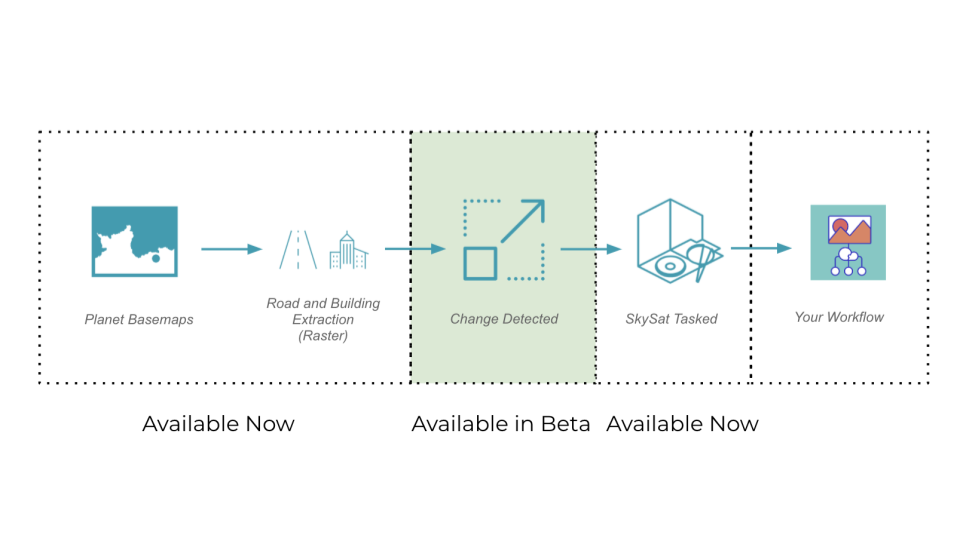

As of today, these two constellations operate independently - Once the GeoJSON geometries from the Change Detection results has been manually extracted, it is possible to use our Tasking API or our Tasking Dashboard to task a SkySat and get a higher-resolution image. It is then possible to run Computer Vision models on SkySat Imagery to extract building footprints and road networks.


For more information on how to task SkySats using the API, check out:
* [Tasking API User Guide](https://developers.planet.com/docs/tasking/)
* [Tasking API Reference Information](https://developers.planet.com/docs/tasking/reference/)

If you’re interested in trying out SkySat tasking, please contact your Sales Representative.

For any additional information or feedback on Change detection, please contact  [Justin Davis](justin@planet.com) and/or [Jonathan Evens](jonathan.evens@planet.com)

*Note: Tasking provides programmatic capabilities (API and GUI implementations) to automatically task satellites that will produce various types of satellite imagery for a certain period of time that is also defined by the end-to-end user.*